In [2]:
import random
import networkx as nx
import gzip
import pandas as pd
import matplotlib.pyplot as plt


from helpers.g_funcs import id2name, out_conns, name2id, in_conns

In [3]:
with gzip.open("wiki-topcats.txt.gz", "rt") as f:
    G = nx.DiGraph()

    for line in f:
        if line.startswith("#") or not line.strip():
            continue

        source, target = line.strip().split()

        G.add_edge(source, target)

In [4]:
average_degree = sum(dict(G.degree()).values()) / float(nx.number_of_nodes(G))

In [5]:
average_degree

31.830289775711712

which countries have the most inbound and outbound connections? and how does that compare to their ranking in world population. You could assume that the more populous countries would have more in and out connections.

- source https://database.earth/population/by-country/2012. 2012 same as graph data

In [4]:
df = pd.read_csv("2012-world-pop-database.earth.csv",index_col=0)
df["Population"] = df["Population"].apply(lambda x: int(x.replace(",", "")))

In [5]:
countries_by_pop = df.Country.reset_index(drop=True)
countries_by_pop = countries_by_pop[0:50]

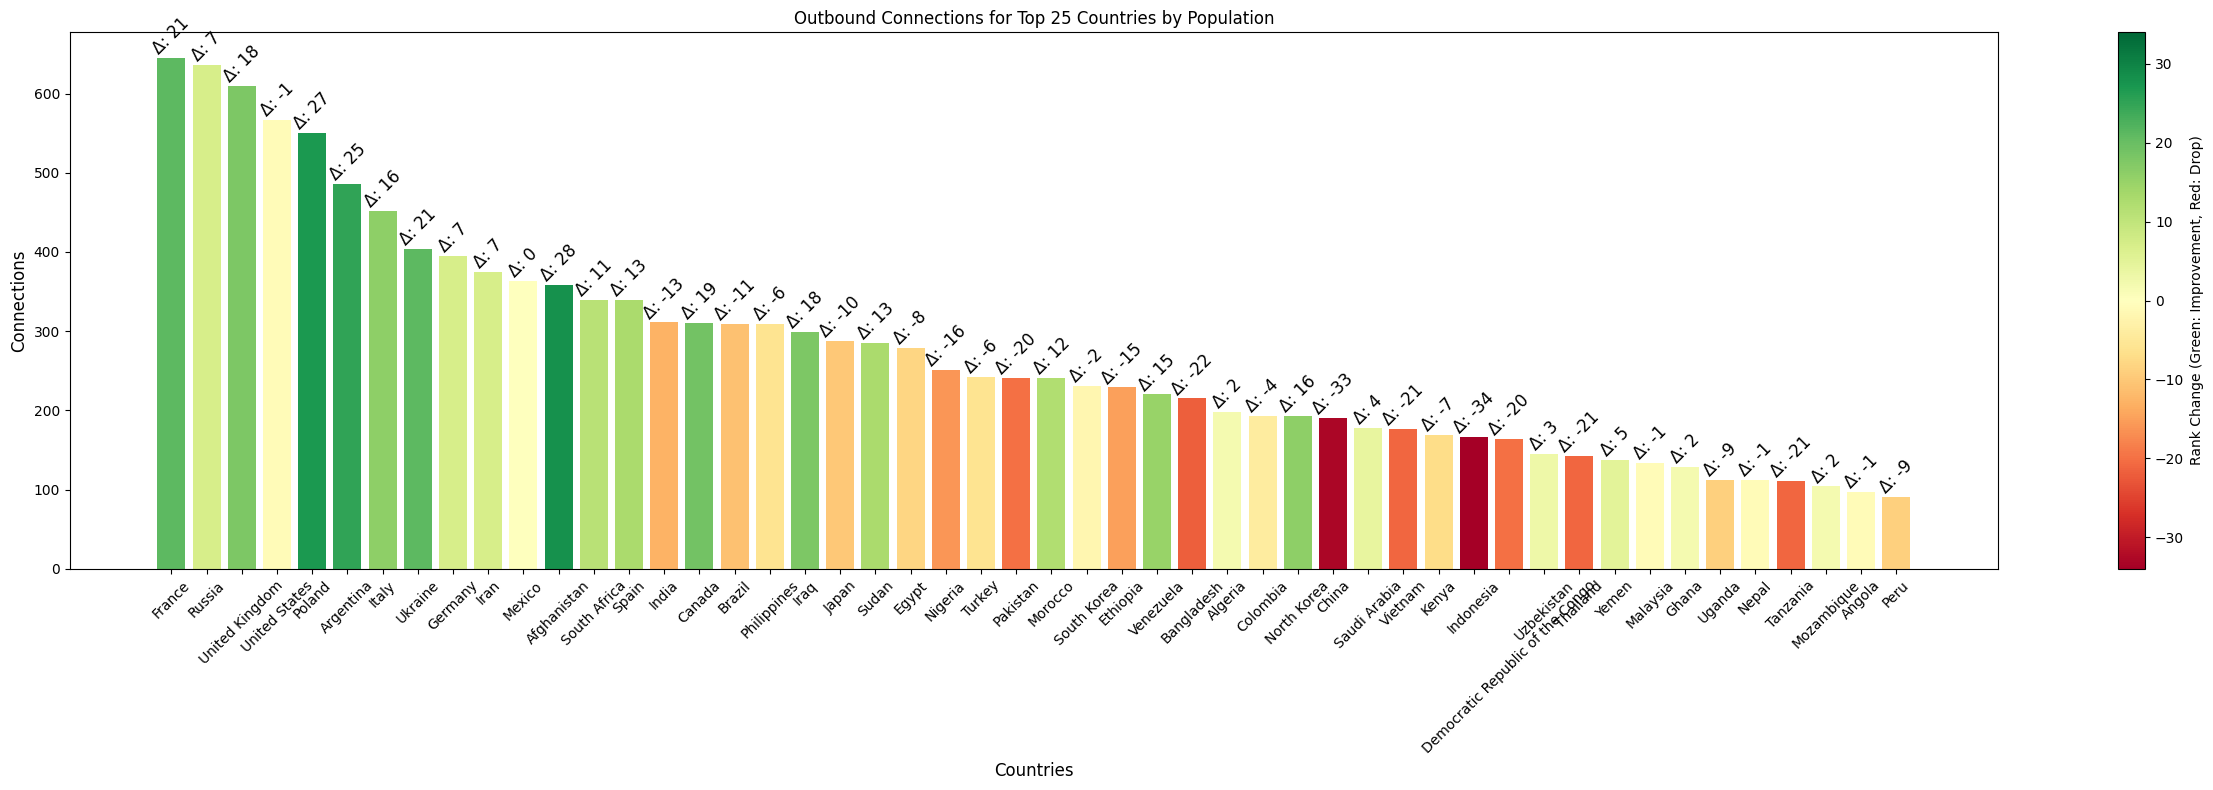

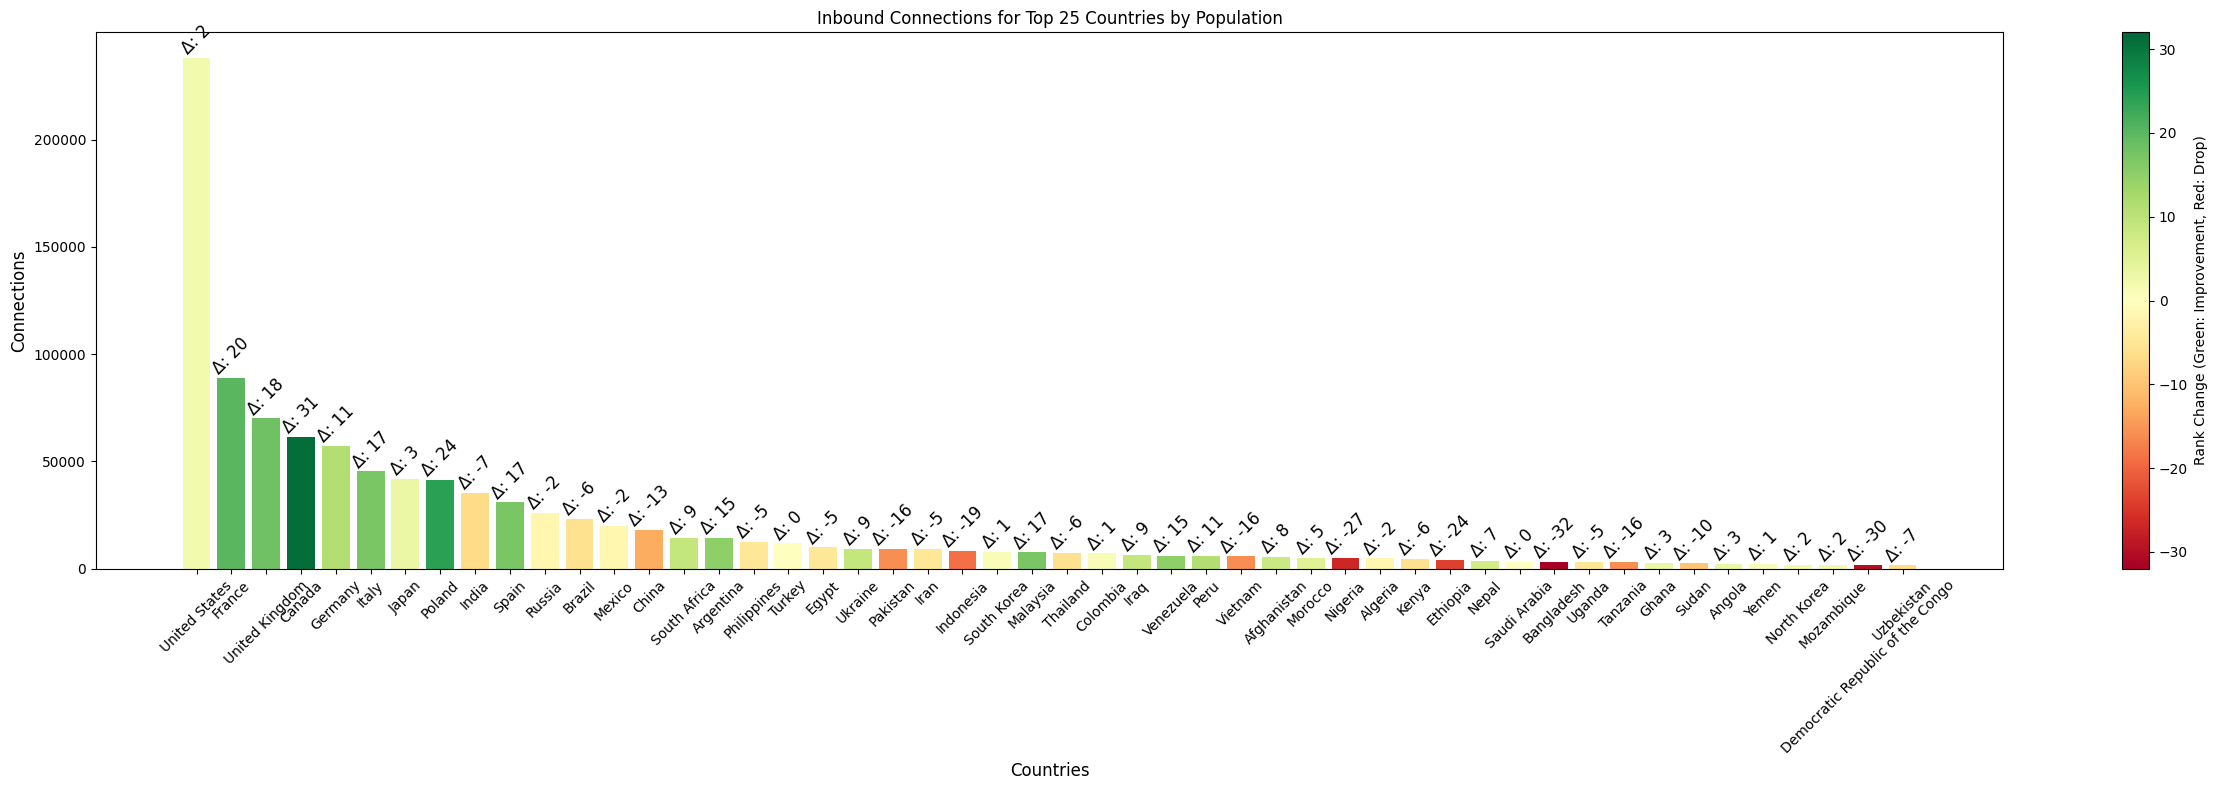

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Assuming the functions name2id, out_conns, in_conns are already defined and working


# Function to annotate bars with original and new ranks, including rank difference
def annotate_bars(ax, countries, original_ranks, new_ranks):
    for rect, country in zip(ax.patches, countries):
        original_rank = original_ranks.get(country, "Unknown")
        new_rank = new_ranks.get(country, "Unknown")
        rank_difference = (
            original_rank - new_rank if original_rank != "Unknown" else "Unknown"
        )
        annotation = f"Δ: {rank_difference}"
        ax.annotate(
            annotation,
            (rect.get_x() + rect.get_width() / 2, rect.get_height()),
            ha="center",
            va="bottom",
            rotation=45,
            fontsize=12,
        )


# Function to collect and process data for plotting
def process_data_for_plotting(countries, conn_function, original_ranks):
    country_connections = []
    for country in countries:
        node_id = name2id(country)  # Convert country name to node ID
        if node_id:  # Ensure the country is in the graph
            connections = len(
                conn_function(G, node_id)
            )  # Get the number of connections using the provided function
            country_connections.append((country, connections))
        else:
            country_connections.append((country, 0))

    # Sort countries by the number of connections in descending order
    country_connections.sort(key=lambda x: x[1], reverse=True)

    # Unpack the sorted country connections into separate lists
    sorted_countries, connections = zip(*country_connections)

    # Calculate new ranks based on the sorted order
    new_ranks = {country: rank + 1 for rank, country in enumerate(sorted_countries)}

    return sorted_countries, connections, new_ranks


# Original ranks based on the population list
original_ranks = {name: rank + 1 for rank, name in enumerate(countries_by_pop)}

# Process data for outbound and inbound connections
countries_out, out_connections, new_ranks_out = process_data_for_plotting(
    countries_by_pop, out_conns, original_ranks
)
countries_in, in_connections, new_ranks_in = process_data_for_plotting(
    countries_by_pop, in_conns, original_ranks
)


# Function to plot connections with color scale
def plot_with_color_scale(ax, countries, connections, original_ranks, new_ranks, title):
    # Calculate rank differences and normalize for color scale
    differences = [
        original_ranks.get(country, len(countries) + 1) - new_ranks.get(country, 0)
        for country in countries
    ]
    max_diff = max(
        abs(min(differences)), max(differences), 1
    )  # Ensure max_diff is not 0 to avoid division by zero
    normalized_diffs = [
        (diff / max_diff + 1) / 2 for diff in differences
    ]  # Normalize to [0, 1]

    cmap = cm.RdYlGn  # Red for drop, green for improvement
    norm = mcolors.Normalize(
        vmin=-max_diff, vmax=max_diff
    )  # Normalization based on the actual rank differences

    bars = ax.bar(
        countries, connections, color=[cmap(norm(diff)) for diff in differences]
    )
    plt.xlabel("Countries", fontsize=12)
    plt.ylabel("Connections", fontsize=12)
    plt.title(title)
    plt.xticks(rotation=45,fontsize=10)

    # Create a scalar mappable for the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # You have to set a dummy array for the ScalarMappable
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Rank Change (Green: Improvement, Red: Drop)")

    return bars


# Plot for Outbound Connections
fig, ax = plt.subplots(figsize=(25, 8))
plot_with_color_scale(
    ax,
    countries_out,
    out_connections,
    original_ranks,
    new_ranks_out,
    "Outbound Connections for Top 25 Countries by Population",
)
annotate_bars(ax, countries_out, original_ranks, new_ranks_out)
plt.tight_layout()
plt.show()

# Plot for Inbound Connections
fig, ax = plt.subplots(figsize=(25, 8))
plot_with_color_scale(
    ax,
    countries_in,
    in_connections,
    original_ranks,
    new_ranks_in,
    "Inbound Connections for Top 25 Countries by Population",
)
annotate_bars(ax, countries_in, original_ranks, new_ranks_in)
plt.tight_layout()
plt.show()

percent of over/under representation according to population. is the distribution of population the same as the distribution of in and out connections? the expected value is the proportion of all of the connections in the graph(of countries) to  that country's proportion of the world population 

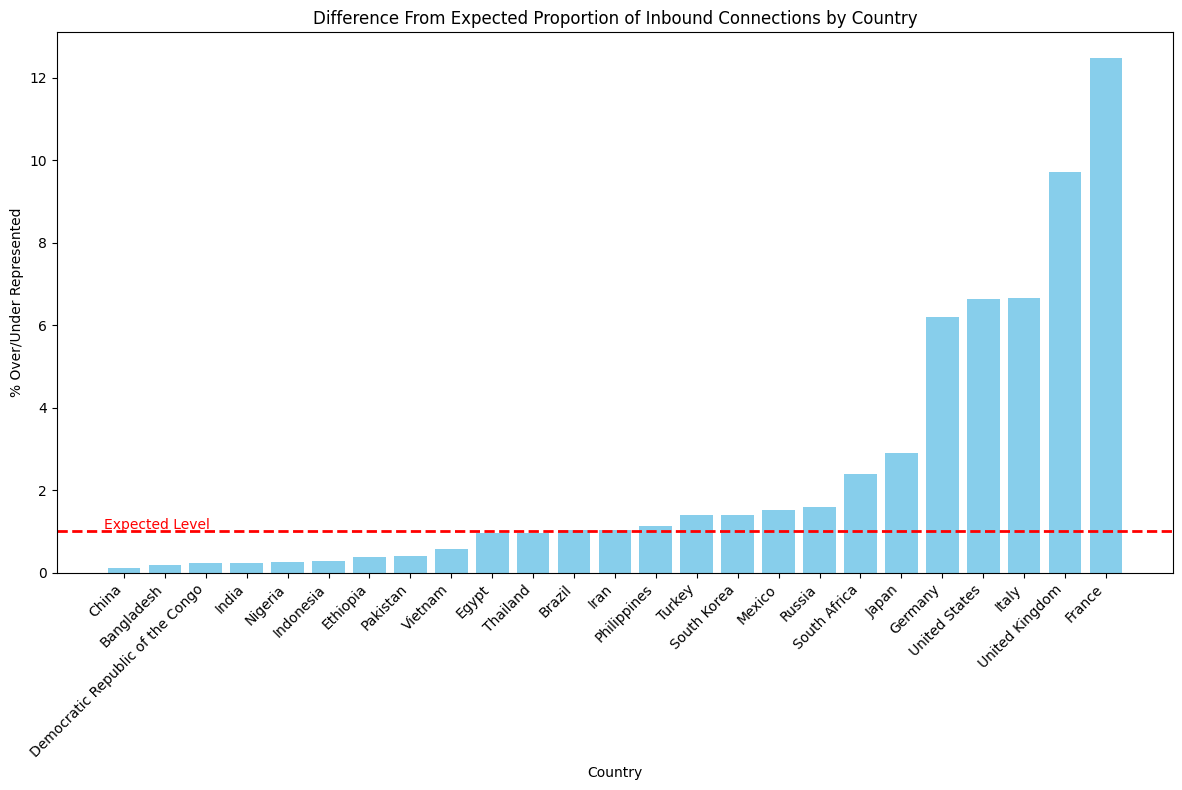

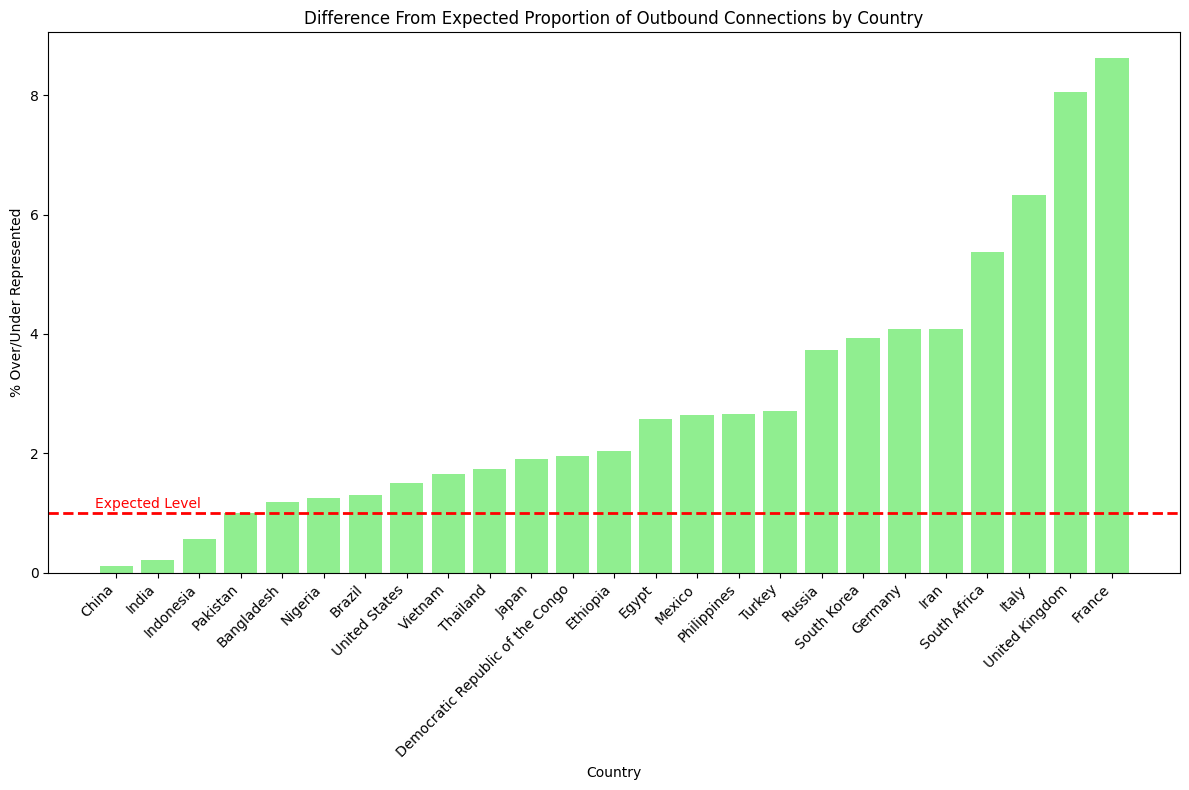

In [136]:
total_in_connections = 0
total_out_connections = 0

for country in countries_by_pop:
    node_id = name2id(country)  #
    if node_id in G:

        total_in_connections += len(list(G.predecessors(node_id)))

        total_out_connections += len(list(G.successors(node_id)))


import pandas as pd

# Prepare data for the new DataFrame
data = {
    "Country": [],
    "Population": [],
    "Actual In Connections": [],
    "Expected In Connections": [],
    "Over/Under In Connections": [],
    "Actual Out Connections": [],
    "Expected Out Connections": [],
    "Over/Under Out Connections": [],
}

for country in countries_by_pop:
    node_id = name2id(country)
    country_population = df.loc[df["Country"] == country, "Population"].values[0]
    pop_proportion = df.loc[df["Country"] == country, "Population Proportion"].values[0]

    expected_in_connections = pop_proportion * total_in_connections
    expected_out_connections = pop_proportion * total_out_connections

    actual_in_connections = len(list(G.predecessors(node_id))) if node_id in G else 0
    actual_out_connections = len(list(G.successors(node_id))) if node_id in G else 0

    over_under_in = actual_in_connections - expected_in_connections
    over_under_out = actual_out_connections - expected_out_connections

    # Add data for this country to the dictionary
    data["Country"].append(country)
    data["Population"].append(country_population)
    data["Actual In Connections"].append(actual_in_connections)
    data["Expected In Connections"].append(expected_in_connections)
    data["Over/Under In Connections"].append(over_under_in)
    data["Actual Out Connections"].append(actual_out_connections)
    data["Expected Out Connections"].append(expected_out_connections)
    data["Over/Under Out Connections"].append(over_under_out)

# Create a DataFrame from the compiled data
connection_df = pd.DataFrame(data)

connection_df["%_over/under_represented_in"] = (
    connection_df["Actual In Connections"] / connection_df["Expected In Connections"]
)

connection_df["%_over/under_represented_out"] = (
    connection_df["Actual Out Connections"] / connection_df["Expected Out Connections"]
)

connection_df.drop(
    [
        "Actual In Connections",
        "Expected In Connections",
        "Over/Under In Connections",
        "Actual Out Connections",
        "Expected Out Connections",
        "Over/Under Out Connections",
        "Population",
    ],
    axis=1,
    inplace=True,
)
import matplotlib.pyplot as plt

# Sort the DataFrame by '%_over/under_represented_in' in descending order
connection_df_sorted_in = connection_df.sort_values(
    by="%_over/under_represented_in", ascending=True
)

# Plotting for Inbound Connections
plt.figure(figsize=(12, 8))
plt.bar(
    connection_df_sorted_in["Country"],
    connection_df_sorted_in["%_over/under_represented_in"],
    color="skyblue",
    label="Inbound",
)

plt.axhline(y=1, color="r", linestyle="--", linewidth=2)
plt.text(x=-0.5, y=1.15, s="Expected Level", color="r", va="center", ha="left")

plt.xlabel("Country")
plt.ylabel("% Over/Under Represented")
plt.title("Difference From Expected Proportion of Inbound Connections by Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Sort the DataFrame by '%_over/under_represented_out' in descending order
connection_df_sorted_out = connection_df.sort_values(
    by="%_over/under_represented_out", ascending=True
)

# Plotting for Outbound Connections
plt.figure(figsize=(12, 8))
plt.bar(
    connection_df_sorted_out["Country"],
    connection_df_sorted_out["%_over/under_represented_out"],
    color="lightgreen",
    label="Outbound",
)

plt.axhline(y=1, color="r", linestyle="--", linewidth=2)
plt.text(x=-0.5, y=1.15, s="Expected Level", color="r", va="center", ha="left")

plt.xlabel("Country")
plt.ylabel("% Over/Under Represented")
plt.title("Difference From Expected Proportion of Outbound Connections by Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()